# Análisis de redes

## Instalar e importar librerías

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
from IPython.display import clear_output
clear_output()

In [ ]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [ ]:
# This cell set up all the required styling

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from matplotlib.patches import FancyBboxPatch

MAIN_COLOR = "#37539C"

BLUE_PALETTE = [
    "#869CD4",
    "#4969BE",
    "#4062BB",
    "#354F95",
    "#2D4175",
    "#27355A"
]

COLOR_PALETTE = [
    MAIN_COLOR,
    "#59C3C3",
    "#F45B69",
    "#52489C",
    "#9FB7B9",
    "#EBEBEB",
    "#4062BB",
    "#46B1C9",
    "#84C0C6",
    "#BCC1BA",
    "#F2E2D2"
]

def install_open_sans():
  """Install Open Sans fonts from directory, and set them as the default
  """
  fonts_dir = "/content/drive/Shareddrives/Estudio Ecosistema CTCI/PT5_Informe Final/open_sans_fonts"
  for font_path in os.listdir(fonts_dir):
    full_path = os.path.join(fonts_dir, font_path)
    fontManager.addfont(full_path)

def set_properties(font_family, main_color, color_palette):
  # Set font
  mpl.rc('font', family=font_family)
  # Set font weight to bold in everything
  mpl.rcParams["font.weight"] = "bold"
  mpl.rcParams["font.weight"] = "bold"
  mpl.rcParams["axes.titleweight"] = "bold"
  mpl.rcParams["axes.labelweight"] = "bold"

  # Set color of text, labels and ticks
  mpl.rcParams['text.color'] = main_color
  mpl.rcParams['axes.labelcolor'] = main_color
  mpl.rcParams['xtick.color'] = main_color
  mpl.rcParams['ytick.color'] = main_color

  # Set default colormap
  mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_palette)

  # Set thant only left and bottom plot spines should be visible
  # (instead of a whole square around the plot)
  mpl.rcParams['axes.spines.left'] = True
  mpl.rcParams['axes.spines.bottom'] = True
  mpl.rcParams['axes.spines.right'] = False
  mpl.rcParams['axes.spines.top'] = False

  # Set horizontal grid
  mpl.rcParams["axes.grid"] = True
  mpl.rcParams["axes.grid.axis"] = "y"
  mpl.rcParams["grid.linestyle"] = "--"

  # Set default linestyle and marker
  mpl.rcParams["lines.linestyle"] = "-"
  mpl.rcParams["lines.marker"] = "o"

  # Set default DPI for image saving (300 is the mininum recommended for printing)
  mpl.rcParams['savefig.dpi'] = 300


install_open_sans()
set_properties("Open Sans", MAIN_COLOR, COLOR_PALETTE)


def round_corners(ax):
  new_patches = []
  old_bottom, old_top = ax.get_ylim()
  for patch in reversed(ax.patches):
      bb = patch.get_bbox()
      if bb.height == 0:
        new_patches.append(patch)
        continue
      color=patch.get_facecolor()
      p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                          abs(bb.width), abs(bb.height),
                          boxstyle="round,pad=-0.0040,rounding_size=0.1",
                          ec="none", fc=color,
                          mutation_aspect=4
                          )
      patch.remove()
      new_patches.append(p_bbox)
  for patch in new_patches:
      ax.add_patch(patch)

  # Fix ylim
  ax.set_ylim(old_bottom, old_top)

## Cargar datos

In [ ]:
data_dir = "/content/drive/Shareddrives/Estudio Ecosistema CTCI/PT2_Sistematización fuentes de información/Análisis/ANID_CORFO/Resultados/CORFO"
df_all = pd.read_excel(os.path.join(data_dir, "data_corfo_final.xlsx"))

In [ ]:
df_all

,id,año_adjudicacion,codigo,instrumento,tipo_relacion,titulo_del_proyecto,rutdv,nombre_razon_social,tipo_ctr_sii,rubro_sii,...,monto_consolidado_ley,rut_valido,nombre_normalizado,rut_dv,nombre_canonico,empresa_tipo,empresa_subtipo,provincia,comuna,tipo_institucion_final
0,1,2023.0,23CH-246113,Capital Humano,BENEFICIARIO / DESARROLLADOR,Nuevas estrategias de microencapsulación para ...,77131055-9,Liva Company SPA,PERSONA JURIDICA COMERCIAL,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,...,NaN,True,LIVA COMPANY SPA,77131055-9,LIVA COMPANY SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,SANTIAGO,SANTIAGO,Empresa
1,2,2023.0,23CH-246116,Capital Humano,BENEFICIARIO / DESARROLLADOR,Aprender haciendo bakeries de bajo índice glic...,77208333-5,ELAB. Y COM. CASONA EL MONTE LTDA,PERSONA JURIDICA COMERCIAL,INDUSTRIA MANUFACTURERA,...,NaN,True,ELAB Y COM CASONA EL MONTE LTDA,77208333-5,ELABORADORA Y COMERCIALIZADORA CASONA EL MONTE...,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,TALAGANTE,EL MONTE,Empresa
2,3,2023.0,23CH-246118,Capital Humano,BENEFICIARIO / DESARROLLADOR,Optimización de medios de cultivo sustentables...,77148405-0,LUYEF BIOTECHNOLOGIES CHILE SPA,PERSONA JURIDICA COMERCIAL,"ACTIVIDADES PROFESIONALES, CIENTIFICAS Y TECNICAS",...,NaN,True,LUYEF BIOTECHNOLOGIES CHILE SPA,77148405-0,LUYEF BIOTECHNOLOGIES CHILE SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,SANTIAGO,PROVIDENCIA,Empresa
3,4,2023.0,23CH-246123,Capital Humano,BENEFICIARIO / DESARROLLADOR,Producción de proteínas recombinantes a partir...,77065948-5,Pewman Innovation spa,PERSONA JURIDICA COMERCIAL,"AGRICULTURA, GANADERIA, SILVICULTURA Y PESCA",...,NaN,True,PEWMAN INNOVATION SPA,77065948-5,PEWMAN INNOVATION SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,CHACABUCO,LAS CONDES,Empresa
4,5,2023.0,23CH-246125,Capital Humano,BENEFICIARIO / DESARROLLADOR,NGB-eDNA. Plataforma genética no-invasiva para...,77063937-9,Ecología y Genética Ambiental SpA,PERSONA JURIDICA COMERCIAL,"ACTIVIDADES PROFESIONALES, CIENTIFICAS Y TECNICAS",...,NaN,True,ECOLOGIA Y GENETICA AMBIENTAL SPA,77063937-9,ECOLOGIA Y GENETICA AMBIENTAL SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,CONCEPCIÓN,CONCEPCION,Empresa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10566,1344,2014.0,PI-998,Ley I+D,mandante,Eficacia y toxicidad del uso de una familia de...,77424780-7,EWOS CHILE ALIMENTOS LIMITADA,PERSONA JURIDICA COMERCIAL,D - INDUSTRIAS MANUFACTURERAS NO METALICAS,...,76835703.0,True,EWOS CHILE ALIMENTOS LIMITADA,77424780-7,EWOS CHILE ALIMENTOS LIMITADA,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,CONCEPCIÓN,CORONEL,Empresa
10567,1345,2018.0,PI-99869,Ley I+D,mandante,Análisis Proteómico por Machine-Learning: Perf...,76221912-3,LABORATORIO PATHOVET LIMITADA,PERSONA JURIDICA COMERCIAL,O - SERVICIOS SOCIALES Y DE SALUD,...,23076375.0,True,LABORATORIO PATHOVET LIMITADA,76221912-3,LABORATORIO PATHOVET LIMITADA,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,LLANQUIHUE,PUERTO MONTT,Empresa
10568,1346,2018.0,PI-99871,Ley I+D,mandante,Desarrollo de un proceso de recubrimiento o lí...,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,"H - COMERCIO AL POR MAYOR Y MENOR, REP. VEH.AU...",...,19770000.0,True,NANOTEC SA,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,SOCIEDADES ANONIMAS CERRADAS,SANTIAGO,SAN BERNARDO,Empresa
10569,1347,2018.0,PI-99872,Ley I+D,mandante,Nuevos usos de nanopartículas metálicas: Desar...,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,"H - COMERCIO AL POR MAYOR Y MENOR, REP. VEH.AU...",...,19800000.0,True,NANOTEC SA,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,SOCIEDADES ANONIMAS CERRADAS,SANTIAGO,SAN BERNARDO,Empresa


Crearemos un dataframe de datos válidos; es decir, donde `tipo_institucion_final` no sea nulo ni "Otra".

In [ ]:
df_valid = df_all[(~df_all["tipo_institucion_final"].isnull()) &
                  (df_all["tipo_institucion_final"] != "Otra")]
df_valid

,id,año_adjudicacion,codigo,instrumento,tipo_relacion,titulo_del_proyecto,rutdv,nombre_razon_social,tipo_ctr_sii,rubro_sii,...,monto_consolidado_ley,rut_valido,nombre_normalizado,rut_dv,nombre_canonico,empresa_tipo,empresa_subtipo,provincia,comuna,tipo_institucion_final
0,1,2023.0,23CH-246113,Capital Humano,BENEFICIARIO / DESARROLLADOR,Nuevas estrategias de microencapsulación para ...,77131055-9,Liva Company SPA,PERSONA JURIDICA COMERCIAL,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,...,NaN,True,LIVA COMPANY SPA,77131055-9,LIVA COMPANY SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,SANTIAGO,SANTIAGO,Empresa
1,2,2023.0,23CH-246116,Capital Humano,BENEFICIARIO / DESARROLLADOR,Aprender haciendo bakeries de bajo índice glic...,77208333-5,ELAB. Y COM. CASONA EL MONTE LTDA,PERSONA JURIDICA COMERCIAL,INDUSTRIA MANUFACTURERA,...,NaN,True,ELAB Y COM CASONA EL MONTE LTDA,77208333-5,ELABORADORA Y COMERCIALIZADORA CASONA EL MONTE...,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,TALAGANTE,EL MONTE,Empresa
2,3,2023.0,23CH-246118,Capital Humano,BENEFICIARIO / DESARROLLADOR,Optimización de medios de cultivo sustentables...,77148405-0,LUYEF BIOTECHNOLOGIES CHILE SPA,PERSONA JURIDICA COMERCIAL,"ACTIVIDADES PROFESIONALES, CIENTIFICAS Y TECNICAS",...,NaN,True,LUYEF BIOTECHNOLOGIES CHILE SPA,77148405-0,LUYEF BIOTECHNOLOGIES CHILE SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,SANTIAGO,PROVIDENCIA,Empresa
3,4,2023.0,23CH-246123,Capital Humano,BENEFICIARIO / DESARROLLADOR,Producción de proteínas recombinantes a partir...,77065948-5,Pewman Innovation spa,PERSONA JURIDICA COMERCIAL,"AGRICULTURA, GANADERIA, SILVICULTURA Y PESCA",...,NaN,True,PEWMAN INNOVATION SPA,77065948-5,PEWMAN INNOVATION SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,CHACABUCO,LAS CONDES,Empresa
4,5,2023.0,23CH-246125,Capital Humano,BENEFICIARIO / DESARROLLADOR,NGB-eDNA. Plataforma genética no-invasiva para...,77063937-9,Ecología y Genética Ambiental SpA,PERSONA JURIDICA COMERCIAL,"ACTIVIDADES PROFESIONALES, CIENTIFICAS Y TECNICAS",...,NaN,True,ECOLOGIA Y GENETICA AMBIENTAL SPA,77063937-9,ECOLOGIA Y GENETICA AMBIENTAL SPA,PERSONA JURIDICA COMERCIAL,SOCIEDAD POR ACCIONES,CONCEPCIÓN,CONCEPCION,Empresa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10566,1344,2014.0,PI-998,Ley I+D,mandante,Eficacia y toxicidad del uso de una familia de...,77424780-7,EWOS CHILE ALIMENTOS LIMITADA,PERSONA JURIDICA COMERCIAL,D - INDUSTRIAS MANUFACTURERAS NO METALICAS,...,76835703.0,True,EWOS CHILE ALIMENTOS LIMITADA,77424780-7,EWOS CHILE ALIMENTOS LIMITADA,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,CONCEPCIÓN,CORONEL,Empresa
10567,1345,2018.0,PI-99869,Ley I+D,mandante,Análisis Proteómico por Machine-Learning: Perf...,76221912-3,LABORATORIO PATHOVET LIMITADA,PERSONA JURIDICA COMERCIAL,O - SERVICIOS SOCIALES Y DE SALUD,...,23076375.0,True,LABORATORIO PATHOVET LIMITADA,76221912-3,LABORATORIO PATHOVET LIMITADA,PERSONA JURIDICA COMERCIAL,SOC. RESPONSABILIDAD LIMITADA,LLANQUIHUE,PUERTO MONTT,Empresa
10568,1346,2018.0,PI-99871,Ley I+D,mandante,Desarrollo de un proceso de recubrimiento o lí...,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,"H - COMERCIO AL POR MAYOR Y MENOR, REP. VEH.AU...",...,19770000.0,True,NANOTEC SA,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,SOCIEDADES ANONIMAS CERRADAS,SANTIAGO,SAN BERNARDO,Empresa
10569,1347,2018.0,PI-99872,Ley I+D,mandante,Nuevos usos de nanopartículas metálicas: Desar...,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,"H - COMERCIO AL POR MAYOR Y MENOR, REP. VEH.AU...",...,19800000.0,True,NANOTEC SA,76082953-6,NANOTEC S.A.,PERSONA JURIDICA COMERCIAL,SOCIEDADES ANONIMAS CERRADAS,SANTIAGO,SAN BERNARDO,Empresa


## Pequeño análisis

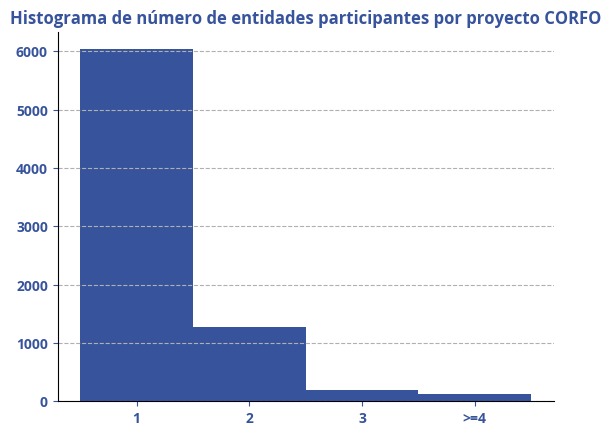

In [ ]:
n_relations_by_id = df_valid.groupby("codigo").count()["id"]
_ = plt.hist(np.clip(n_relations_by_id, 0, 4), bins=range(1, 6) )
_ = plt.title("Histograma de número de entidades participantes por proyecto CORFO")
_ = plt.xticks(np.arange(1.5, 4.500001, 1), [1, 2, 3, ">=4"])

In [ ]:
df_valid["tipo_institucion_final"].value_counts(dropna=False)

Empresa                                   7743
Institución Privada Sin Fines de Lucro     971
Institución de Educación Superior          938
Estado                                     275
Internacional                                9
Name: tipo_institucion_final, dtype: int64

In [ ]:
grouped_df = df_valid.groupby("codigo").agg({"nombre_canonico": lambda x: x})
grouped_df

,nombre_canonico
codigo,
11ETN-12097,"INSTITUTO NACIONAL DE TECNOLOGIA, ESTANDARIZAC..."
11FBCT-12991,INNOVACION Y TECNOLOGIA VITIVINICOLA S.A
11IEI-11916,CEIBO COMERCIAL SPA
11IEI-12162,VCL S.A.
11IEI-12756,SIMA DIGITAL SA EN LIQUIDACION
...,...
PI-998,EWOS CHILE ALIMENTOS LIMITADA
PI-99869,LABORATORIO PATHOVET LIMITADA
PI-99871,NANOTEC S.A.


In [ ]:
len(df_valid)

9936

## Grafos

### Grafos simples (consolidados por tipo de institución)

In [ ]:
def deg2rad(degrees):
  return np.pi*degrees/180

def generate_pentagon(radius=1, rotation=0):
  angles = np.array([18, 90, 162, 234, 306])+ rotation
  coords = np.array([(radius*np.cos(deg2rad(angle)), radius*np.sin(deg2rad(angle))) for angle in angles])
  return coords

def generate_square(radius=1):
  angles = np.array([45, 135, 225, 315])
  coords = np.array([(radius*np.cos(deg2rad(angle)), radius*np.sin(deg2rad(angle))) for angle in angles])
  return coords

def get_map_names_institutions(df):
  name2inst = {}
  unique_names = df_valid["nombre_canonico"].unique()
  for name in unique_names:
    inst_type = df_valid.loc[df_valid["nombre_canonico"] == name, "tipo_institucion_final"].unique()
    assert len(inst_type) == 1
    name2inst[name] = inst_type[0]
  return name2inst

def count_relations(df,
                    agg_column="tipo_institucion_final",
                    normalize=True):
  grouped_df = df.groupby("codigo").agg({agg_column: lambda x: x})
  # Generate weights
  ## Count the number of relations
  counts = defaultdict(lambda: 0)
  for project_id, row in tqdm(grouped_df.iterrows()):
    institutions = row[agg_column]
    if type(institutions) == str:
      continue
    combinations = [sorted(comb) for comb in itertools.combinations(institutions, 2)]
    for (u, v) in combinations:
      counts[(u,v)] += 1

  ## Normalize
  if normalize:
    total = sum(counts.values())
    weights = {key: (value / total) for key, value in counts.items()}
    return weights

  return counts

def count_relations_2(df,
                      map_names_inst,
                      normalize=True,
                      remove_self_loops=True):
  grouped_df = df.groupby("codigo").agg({"nombre_canonico": lambda x: x})
  # Generate weights
  ## Count the number of relations
  counts = defaultdict(lambda: 0)
  for project_id, row in tqdm(grouped_df.iterrows()):
    institutions = row["nombre_canonico"]
    if type(institutions) == str:
      continue
    if remove_self_loops:
      institutions = set(institutions)

    inst_types = [map_names_inst[name] for name in institutions]
    combinations = [sorted(comb) for comb in itertools.combinations(inst_types, 2)]
    for (u, v) in combinations:
      counts[(u,v)] += 1

  ## Normalize
  if normalize:
    total = sum(counts.values())
    weights = {key: (value / total) for key, value in counts.items()}
    return weights

  return counts



def generate_agg_graph(df,
                       map_names_inst,
                       agg_column="tipo_institucion_final"):

  weights = count_relations_2(df, map_names_inst, normalize=True, remove_self_loops=False)
  # Generate graph
  graph = nx.Graph()
  ## Add nodes
  for node in sorted(df[agg_column].unique()):
    graph.add_node(node)

  ## Add edges
  for ((u, v)), weight in weights.items():
    graph.add_edge(u, v, weight=weight)
  return graph

def plot_agg_graph(graph,
                   ax=None,
                   node_size=1000,
                   factor_loops=10,
                   factor_edges=50,
                   pos=None,
                   labels=None,
                   colors=None):

  # Draw the graph
  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  ## Generate positions, labels and colors
  if pos is None:
    coords = generate_pentagon(rotation=36)
    pos = {node: coords[index] for index, node in enumerate(graph.nodes)}
  if not labels:
    labels = {node:node for node in graph.nodes}
  if not colors:
    colors = "tab:blue"

  nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=node_size, node_color=colors)
  for (u, v, d) in graph.edges(data=True):
    width = d["weight"]*factor_loops if (u == v) else d["weight"]*factor_edges
    nx.draw_networkx_edges(graph, pos, ax=ax, edgelist=[(u, v)], width=width, edge_color="dimgrey", arrows=True)

  nx.draw_networkx_labels(graph, pos, ax=ax, labels=labels, font_size=8, font_family="sans-serif", font_color="white")
  plt.tight_layout()

7626it [00:00, 16060.00it/s]


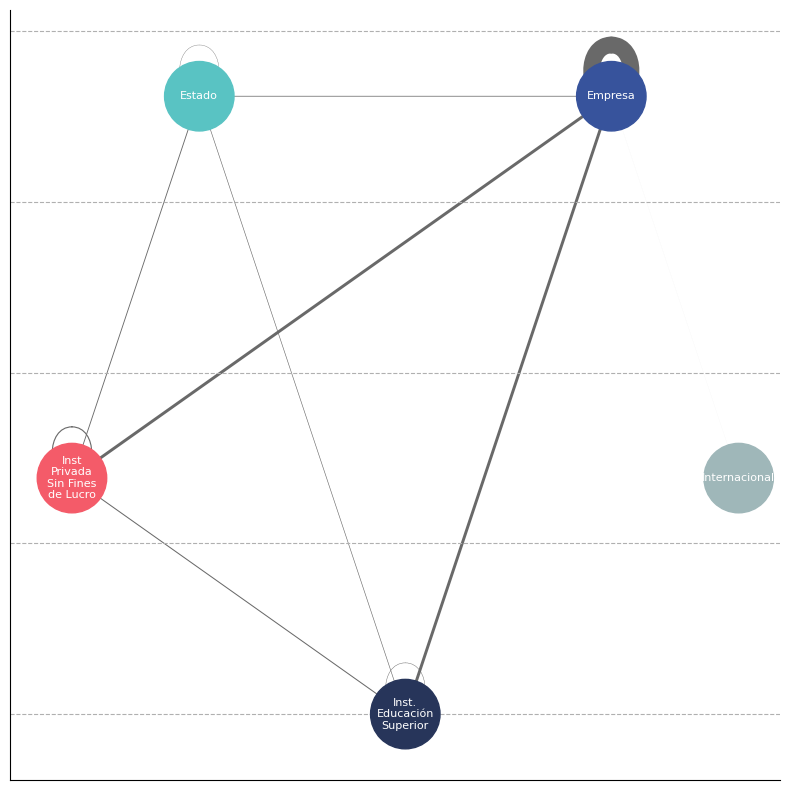

In [ ]:
labels = {
  "Institución de Educación Superior": "Inst.\nEducación\nSuperior",
  "Institución Privada Sin Fines de Lucro": "Inst\nPrivada\nSin Fines\nde Lucro",
  "Estado": "Estado",
  "Empresa": "Empresa",
  "Internacional": "Internacional"
}

color_map = {
  "Empresa": COLOR_PALETTE[0],
  "Estado": COLOR_PALETTE[1],
  "Institución Privada Sin Fines de Lucro": COLOR_PALETTE[2],
  "Institución de Educación Superior": BLUE_PALETTE[5],
  "Internacional": COLOR_PALETTE[4],
}
colors = color_map.values()

df_to_plot = df_valid

map_names_inst = get_map_names_institutions(df_valid)
graph = generate_agg_graph(df_to_plot, map_names_inst)
plot_agg_graph(graph, labels=labels, colors=colors, node_size=2500, factor_loops=20, factor_edges=20)

#### Gráficos de evolución

In [ ]:
map_names_inst = get_map_names_institutions(df_valid)

In [ ]:
inst_types = ["Empresa", "Estado", "Institución Privada Sin Fines de Lucro", "Institución de Educación Superior",  "Internacional"]

counts = {}
for year in range(2016, 2024):
  current_df = df_valid.loc[df_valid["año_adjudicacion"] == year]
  current_count = count_relations(current_df, normalize=False)

  # Since current_count is defaultdict, with this lines we make sure to fill with zero
  # each tuple combination (not product) that it's not currently in the dict
  for it1, it2 in itertools.combinations(sorted(inst_types), 2):
    current_count[(it1, it2)]
  counts[year] = current_count

df_counts = pd.DataFrame(counts).sort_index().reset_index()
## Append symmetrical rows
rows_to_append = []
for iii in range(1, 5):
  for jjj in range(iii):
    print(inst_types[iii], inst_types[jjj])
    try:
      current_row = df_counts.loc[(df_counts["level_0"] == inst_types[jjj]) &
                                  (df_counts["level_1"] == inst_types[iii]),
                                  range(2016, 2024)].values[0]
      current_row = [inst_types[iii], inst_types[jjj]] + list(current_row)
    except IndexError:
      current_row = [inst_types[iii], inst_types[jjj]] + [0]*8
    finally:
      rows_to_append.append(current_row)

rows_to_append.append(["Internacional", "Internacional", 0, 0, 0, 0, 0, 0, 0, 0])
df_counts = pd.concat((df_counts, pd.DataFrame(rows_to_append, columns=df_counts.columns)), ignore_index=True).fillna(0)
df_counts

870it [00:00, 12639.31it/s]
1048it [00:00, 12585.91it/s]
707it [00:00, 12507.16it/s]
494it [00:00, 11480.10it/s]
667it [00:00, 14324.93it/s]
864it [00:00, 13232.50it/s]
585it [00:00, 13268.52it/s]
204it [00:00, 12639.42it/s]


Estado Empresa
Institución Privada Sin Fines de Lucro Empresa
Institución Privada Sin Fines de Lucro Estado
Institución de Educación Superior Empresa
Institución de Educación Superior Estado
Institución de Educación Superior Institución Privada Sin Fines de Lucro
Internacional Empresa
Internacional Estado
Internacional Institución Privada Sin Fines de Lucro
Internacional Institución de Educación Superior


,level_0,level_1,2016,2017,2018,2019,2020,2021,2022,2023
0,Empresa,Empresa,108.0,117.0,79.0,99.0,314.0,267.0,110.0,59.0
1,Empresa,Estado,46.0,28.0,16.0,11.0,5.0,3.0,10.0,10.0
2,Empresa,Institución Privada Sin Fines de Lucro,61.0,42.0,48.0,46.0,88.0,97.0,62.0,28.0
3,Empresa,Institución de Educación Superior,46.0,31.0,33.0,79.0,91.0,98.0,76.0,46.0
4,Empresa,Internacional,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,Estado,Estado,29.0,9.0,8.0,3.0,0.0,0.0,0.0,0.0
6,Estado,Institución Privada Sin Fines de Lucro,60.0,27.0,21.0,17.0,1.0,0.0,2.0,1.0
7,Estado,Institución de Educación Superior,35.0,25.0,13.0,12.0,1.0,0.0,0.0,1.0
8,Estado,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Institución Privada Sin Fines de Lucro,Institución Privada Sin Fines de Lucro,32.0,27.0,31.0,24.0,4.0,4.0,2.0,0.0


<ipython-input-20-bf994960ec60>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_row = current_df[df_counts["level_1"] == it2].values[0][2:]


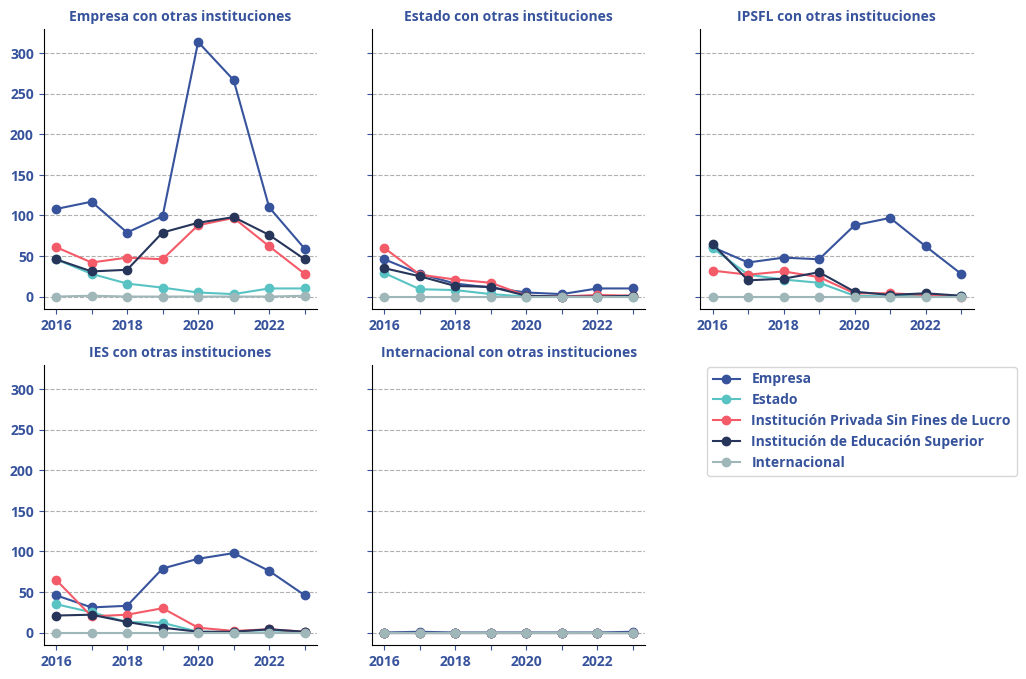

In [ ]:
colors = color_map

labels_map = {
    "Empresa": "Empresa",
    "Estado": "Estado",
    "Institución Privada Sin Fines de Lucro": "IPSFL",
    "Institución de Educación Superior": "IES",
    "Internacional": "Internacional"
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
for it1, ax in zip(inst_types, axes.flatten()):
  current_df = df_counts[df_counts["level_0"] == it1]
  for it2 in inst_types:
    current_row = current_df[df_counts["level_1"] == it2].values[0][2:]
    ax.plot(current_row, label=it2, color=colors[it2])
    ax.set_title(labels_map[it1] + " con otras instituciones", fontsize=10)
    ax.set_xticks(range(8))
    ax.set_xticklabels([2016, "", 2018, "", 2020, "", 2022, ""])

#_ = fig.suptitle('Número de relaciones entre instituciones, entre 2016 y 2023, según proyectos CORFO', fontsize=14, y=0.92)
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.8))
fig.delaxes(axes[1, 2])

### Grafos complejos (desagregados)

In [ ]:
def generate_sparse_graph(df,
                          include_isolated=True,
                          remove_self_loops=True):
  grouped_df = df.groupby("codigo").agg({"nombre_canonico": lambda x: x})
  counts = defaultdict(lambda: 0)
  for project_id, row in grouped_df.iterrows():
    institutions = row["nombre_canonico"]
    if type(institutions) == str:
      continue
    if remove_self_loops:
      institutions = set(institutions)
    combinations = itertools.combinations(institutions, 2)
    for (u, v) in combinations:
      counts[(u,v)] += 1

  # Create graph
  graph = nx.Graph()
  names_institution_types = df.groupby("nombre_canonico", as_index=False)["tipo_institucion_final"].first()
  for _, row in names_institution_types.iterrows():
    name = row["nombre_canonico"]
    inst_type = row["tipo_institucion_final"]
    graph.add_node(name, institution_type=inst_type)

  for ((u, v)), count in counts.items():
    graph.add_edge(u, v, weight=count)

  if not include_isolated:
    graph.remove_nodes_from(list(nx.isolates(graph)))
  return graph


In [ ]:
def plot_sparse_graph(graph,
                      ax=None,
                      colors=None,
                      fontsize=40,
                      nodesize=40):
  # Generate positions for each subgraph
  company_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Empresa"]
  state_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Estado"]
  ies_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Institución de Educación Superior"]
  ipsfl_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Institución Privada Sin Fines de Lucro"]
  international_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Internacional"]

  coords = generate_pentagon(radius=3, rotation=36)
  pos_company = nx.spring_layout(graph.subgraph(company_nodes), center=coords[0])
  pos_state = nx.spring_layout(graph.subgraph(state_nodes), center=coords[1])
  pos_ipsfl = nx.spring_layout(graph.subgraph(ipsfl_nodes), center=coords[2])
  pos_ies = nx.spring_layout(graph.subgraph(ies_nodes), center=coords[3])
  pos_international = nx.spring_layout(graph.subgraph(international_nodes), center=coords[4])

  pos_all = dict(pos_state)
  pos_all.update(pos_ies)
  pos_all.update(pos_ipsfl)
  pos_all.update(pos_company)
  pos_all.update(pos_international)

  # Draw
  if not colors:
    colors = ["tab:blue", "tab:purple", "tab:brown", "tab:olive", "sandybrown"]

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(60, 60))

  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=company_nodes, node_color=colors[0], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=state_nodes, node_color=colors[1], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=ipsfl_nodes, node_color=colors[2], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=ies_nodes, node_color=colors[3], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=international_nodes, node_color=colors[4], ax=ax, node_size=nodesize)

  nx.draw_networkx_edges(graph, pos=pos_all, ax=ax, alpha=0.5, style="dashed", edge_color="lightgray")

  patch_companies = mpatches.Patch(color=colors[0], label='Empresa')
  patch_state = mpatches.Patch(color=colors[1], label='Estado')
  patch_ipsfl = mpatches.Patch(color=colors[2], label='Institución Privada Sin Fines de Lucro')
  patch_ies = mpatches.Patch(color=colors[3], label='Institución de Educación Superior')
  patch_international = mpatches.Patch(color=colors[4], label='Internacional')
  ax.legend(handles=[patch_companies, patch_state, patch_ipsfl, patch_ies, patch_international], fontsize=fontsize, loc="lower right")
  ax.spines.top.set_visible(True)
  ax.spines.bottom.set_visible(True)
  ax.spines.left.set_visible(True)
  ax.spines.right.set_visible(True)
  plt.grid(False)
  plt.tight_layout()

#### Dibujar grafos

##### Con self-loops

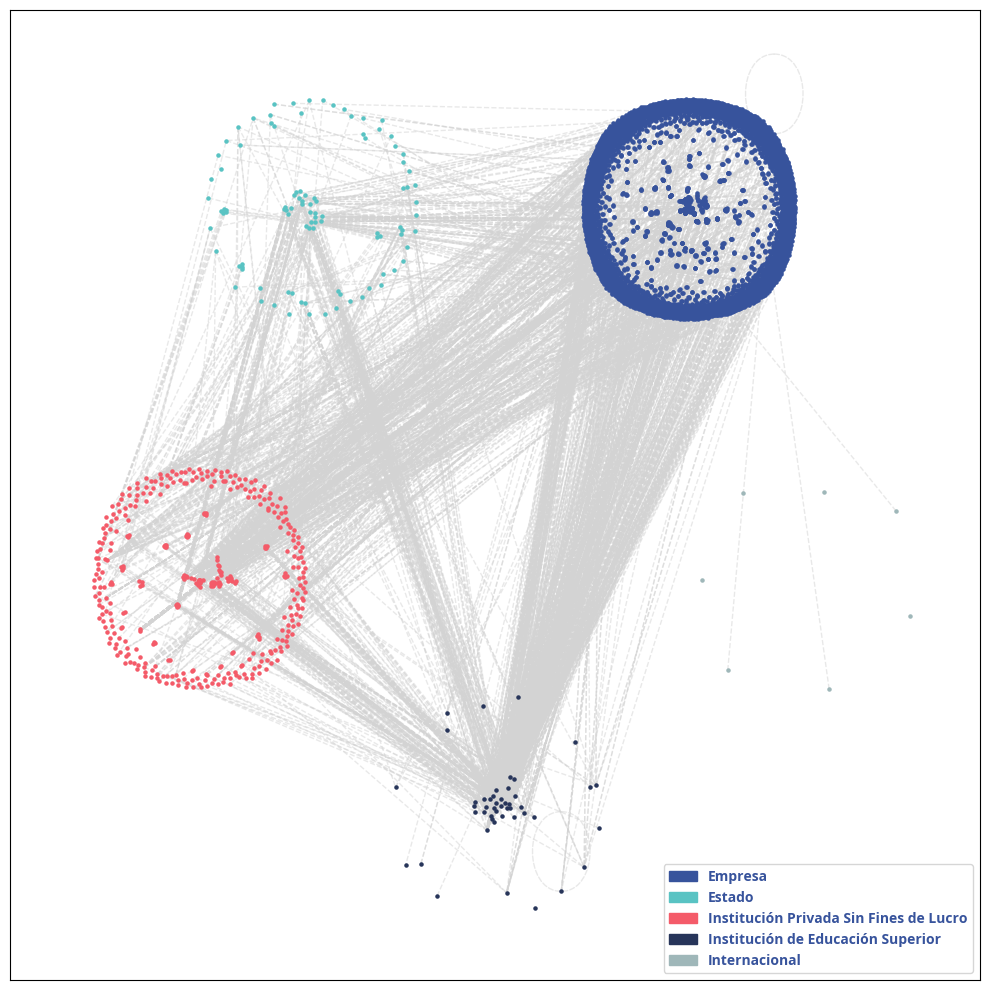

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, remove_self_loops=False)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

##### Sin self-loops

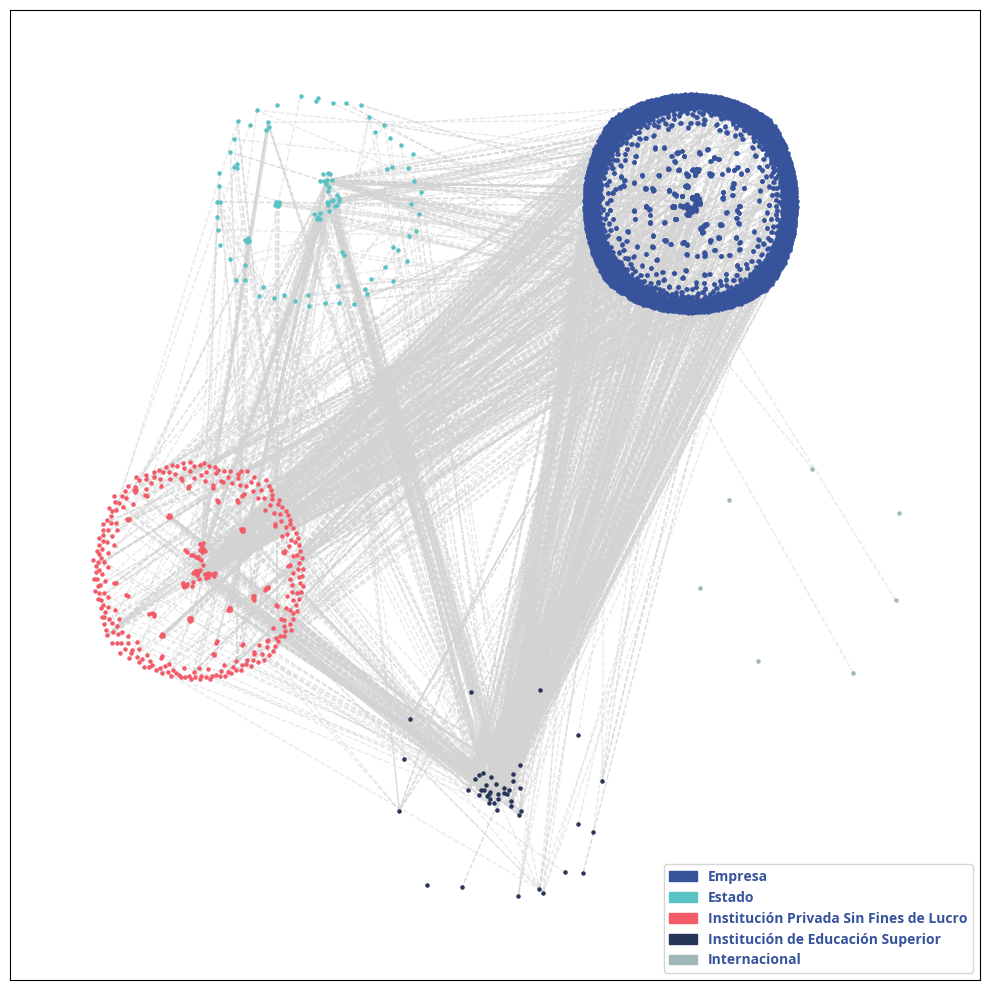

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, remove_self_loops=True)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

##### Sin nodos aislados (y con self-loops)

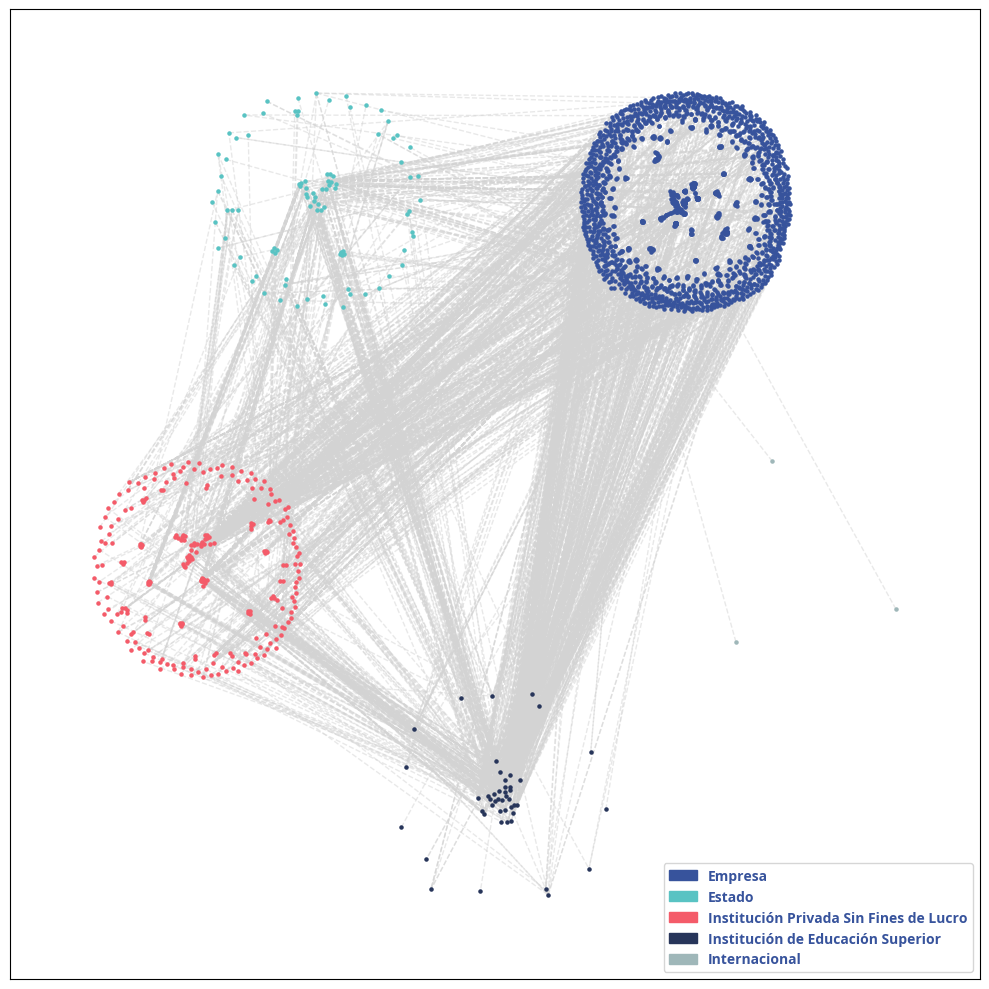

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, include_isolated=False)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
for year, ax in zip(range(2016, 2024), axes.flatten()):
  current_df = df_valid.loc[df_valid["año_adjudicacion"] == year]
  current_graph = generate_sparse_graph(current_df, include_isolated=True)
  plot_sparse_graph(current_graph, ax=ax, fontsize=5, nodesize=2, colors=list(color_map.values()))
  ax.set_title(f"Año {year}")


Output hidden; open in https://colab.research.google.com to view.

### Centralidad de grado

In [ ]:
def remove_edges_with_type(graph,
                           map_names_inst,
                           remove_type="Institución de Educación Superior"):
  graph_copy = graph.copy()
  to_remove = []
  for (u, v) in graph.edges():
    if map_names_inst[u] == map_names_inst[v] == remove_type:
      to_remove.append((u, v))
  graph_copy.remove_edges_from(to_remove)
  return graph_copy



def calculate_centrality(df, map_names_institutions, remove_ies=False, remove_self_loops=False):
  graph = generate_sparse_graph(df, remove_self_loops=remove_self_loops)
  if remove_ies:
    graph = remove_edges_with_type(graph, map_names_institutions)
  return nx.degree_centrality(graph)

def get_centralities(df, remove_self_loops=False, remove_ies=False, names2inst=None):
  if not names2inst:
    names2inst = get_map_names_institutions(df)
  centralities = {}
  for year in range(2016, 2024):
    current_df = df.loc[df["año_adjudicacion"] == year]
    centralities[year] = calculate_centrality(current_df, names2inst, remove_self_loops=remove_self_loops, remove_ies=remove_ies)

  df_centralities = pd.DataFrame(centralities)
  df_centralities["institución"] = df_centralities.index.to_series().apply(lambda x: names2inst[x])
  return df_centralities

def get_top_centralities(df_cent, df_whole, names2inst, n_top=10):
  all_top = []
  for year in range(2016, 2024):
    top_year_series = df_cent.sort_values(by=year, ascending=False)[:n_top]
    top_names = top_year_series.index.values
    top_values = top_year_series[year].values
    top_institutions = top_year_series["institución"].values
    n_projects = [len(df_whole.loc[(df_whole["nombre_canonico"] == name) & (df_whole["año_adjudicacion"] == year), "codigo"].unique())
                    for name in top_names]
    all_top.append(top_names)
    all_top.append(top_values)
    all_top.append(top_institutions)
    all_top.append(n_projects)
  column_names = itertools.chain.from_iterable([(f"nombres_{year}", f"centralidad_{year}", f"instituciones_{year}", f"n_proyectos_{year}") for year in range(2016, 2024)])
  return pd.DataFrame(np.array(all_top).T, columns=column_names)

In [ ]:
names2inst = get_map_names_institutions(df_valid)

In [ ]:
df_cent = get_centralities(df_valid, names2inst=names2inst)
df_top = get_top_centralities(df_cent, df_valid, names2inst=names2inst)
df_top

,nombres_2016,centralidad_2016,instituciones_2016,n_proyectos_2016,nombres_2017,centralidad_2017,instituciones_2017,n_proyectos_2017,nombres_2018,centralidad_2018,...,instituciones_2021,n_proyectos_2021,nombres_2022,centralidad_2022,instituciones_2022,n_proyectos_2022,nombres_2023,centralidad_2023,instituciones_2023,n_proyectos_2023
0,UNIVERSIDAD DE TALCA,0.035539,Institución de Educación Superior,4,UNIVERSIDAD DE TALCA,0.019129,Institución de Educación Superior,3,UNIVERSIDAD DE LA FRONTERA,0.023188,...,Institución Privada Sin Fines de Lucro,31,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,0.036977,Institución Privada Sin Fines de Lucro,23,UNIVERSIDAD DE CHILE,0.041667,Institución de Educación Superior,8
1,UNIVERSIDAD AUSTRAL DE CHILE,0.031863,Institución de Educación Superior,7,UNIVERSIDAD TECNOLOGICA DE CHILE INACAP,0.017003,Institución de Educación Superior,7,ASESORIAS COMERCIALES Y DE NEGOCIACION DAIRYTR...,0.013043,...,Institución de Educación Superior,18,UNIVERSIDAD DE CHILE,0.027331,Institución de Educación Superior,13,UNIVERSIDAD DE CONCEPCION,0.026515,Institución de Educación Superior,7
2,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.029412,Estado,8,DESEIS SPA,0.014878,Empresa,1,ROCK RIVER LAB CHILE SPA,0.013043,...,Institución Privada Sin Fines de Lucro,17,UNIVERSIDAD DE CONCEPCION,0.027331,Institución de Educación Superior,14,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,0.026515,Institución Privada Sin Fines de Lucro,6
3,UNIVERSIDAD DE CONCEPCION,0.025735,Institución de Educación Superior,7,EXE INGENIERIA & SOFTWARE LTDA,0.014878,Empresa,2,SOCIEDAD AGRICOLA LOS TILOS LIMITADA,0.013043,...,Institución de Educación Superior,12,CENTRO TECNOLOGICO EN INNOVACION PARA LA INDUS...,0.019293,Institución Privada Sin Fines de Lucro,15,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.026515,Estado,5
4,UNIVERSIDAD DEL BIO BIO,0.023284,Institución de Educación Superior,4,TECNOLOGIAS MOVILES MOVILGO SPA,0.014878,Empresa,1,AGRICOLA ALMASOL LIMITADA,0.013043,...,Institución de Educación Superior,11,FUNDACION LEITAT CHILE,0.014469,Institución Privada Sin Fines de Lucro,6,VINA CONCHA Y TORO S A,0.022727,Empresa,4
5,UNIVERSIDAD DE CHILE,0.022059,Institución de Educación Superior,6,EXPORTADORA SOLYMAR LIMITADA EN LIQUIDACION,0.014878,Empresa,1,SOC AGRIC Y GANAD CUN CUN LTDA,0.013043,...,Empresa,2,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.012862,Estado,6,FUNDACION LEITAT CHILE,0.018939,Institución Privada Sin Fines de Lucro,5
6,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.017157,Institución de Educación Superior,5,SIDEKICK SPA,0.014878,Empresa,1,SOC AGRICOLA SANTA EMILIA LIMITADA,0.013043,...,Institución de Educación Superior,8,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.011254,Institución de Educación Superior,6,SOCIEDAD AGRICOLA HACIENDA MAL PASO SPA,0.015152,Empresa,2
7,ASOCIACION GREMIAL DE MITICULTORES DE CHILE,0.014706,Institución Privada Sin Fines de Lucro,1,AGROPECUARIA WAPRI S A,0.014878,Empresa,1,GANALAC SOCIEDAD ANONIMA,0.013043,...,Empresa,1,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.011254,Institución de Educación Superior,9,CENTRO TECNOLOGICO EN INNOVACION PARA LA INDUS...,0.015152,Institución Privada Sin Fines de Lucro,4
8,ASOCIACION GREMIAL,0.014706,Institución Privada Sin Fines de Lucro,1,EXPORTADORA FRUTIFOR LIMITADA,0.014878,Empresa,1,MARIO CALDERON BLANCO,0.013043,...,Empresa,1,CENTRO DE ESTUDIOS EN ALIMENTOS PROCESADOS,0.009646,Institución Privada Sin Fines de Lucro,5,UNIVERSIDAD NACIONAL ANDRES BELLO,0.015152,Institución de Educación Superior,2
9,"ASOCIACION GREMIAL DE ACUICULTORES,PESCADORES ...",0.014706,Institución Privada Sin Fines de Lucro,1,AGRONET SPA,0.014878,Empresa,1,ADDVISE SPA,0.013043,...,Empresa,1,UNIVERSIDAD AUSTRAL DE CHILE,0.009646,Institución de Educación Superior,3,REBORN ELECTRIC MOTORS SPA,0.011364,Empresa,2


In [ ]:
for year in range(2016, 2024):
  print(year)
  display(df_top.loc[df_top[f"instituciones_{year}"] != "Institución de Educación Superior", [f"nombres_{year}", f"instituciones_{year}"]])

2016


,nombres_2016,instituciones_2016
2,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado
7,ASOCIACION GREMIAL DE MITICULTORES DE CHILE,Institución Privada Sin Fines de Lucro
8,ASOCIACION GREMIAL,Institución Privada Sin Fines de Lucro
9,"ASOCIACION GREMIAL DE ACUICULTORES,PESCADORES ...",Institución Privada Sin Fines de Lucro


2017


,nombres_2017,instituciones_2017
2,DESEIS SPA,Empresa
3,EXE INGENIERIA & SOFTWARE LTDA,Empresa
4,TECNOLOGIAS MOVILES MOVILGO SPA,Empresa
5,EXPORTADORA SOLYMAR LIMITADA EN LIQUIDACION,Empresa
6,SIDEKICK SPA,Empresa
7,AGROPECUARIA WAPRI S A,Empresa
8,EXPORTADORA FRUTIFOR LIMITADA,Empresa
9,AGRONET SPA,Empresa


2018


,nombres_2018,instituciones_2018
1,ASESORIAS COMERCIALES Y DE NEGOCIACION DAIRYTR...,Empresa
2,ROCK RIVER LAB CHILE SPA,Empresa
3,SOCIEDAD AGRICOLA LOS TILOS LIMITADA,Empresa
4,AGRICOLA ALMASOL LIMITADA,Empresa
5,SOC AGRIC Y GANAD CUN CUN LTDA,Empresa
6,SOC AGRICOLA SANTA EMILIA LIMITADA,Empresa
7,GANALAC SOCIEDAD ANONIMA,Empresa
8,MARIO CALDERON BLANCO,Empresa
9,ADDVISE SPA,Empresa


2019


,nombres_2019,instituciones_2019
2,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado
4,FUNDACION CHILE,Institución Privada Sin Fines de Lucro
5,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,Institución Privada Sin Fines de Lucro
7,CENTRO DE ESTUDIOS EN ALIMENTOS PROCESADOS,Institución Privada Sin Fines de Lucro
8,ASOCIACION DE EMPRESAS DE ALIMENTOS DE CHILE A G,Empresa
9,FEDERACION DE EMPRESAS DE TURISMO DE CHILE - F...,Institución Privada Sin Fines de Lucro


2020


,nombres_2020,instituciones_2020
1,SALMONES MULTIEXPORT S.A.,Empresa
2,SALMONES AYSEN S.A.,Empresa
3,SALMONES CAMANCHACA S A,Empresa
4,SALMONES PACIFIC STAR S A,Empresa
5,SALMONOIL S A,Empresa
6,CULTIVOS YADRAN S A,Empresa
7,MOWI CHILE S.A.,Empresa
8,"ACUICOLA, INMOBILIARIA E INVERSIONES ARAUCANIA...",Empresa
9,CALETA BAY MAR SPA,Empresa


2021


,nombres_2021,instituciones_2021
0,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,Institución Privada Sin Fines de Lucro
2,CENTRO TECNOLOGICO EN INNOVACION PARA LA INDUS...,Institución Privada Sin Fines de Lucro
5,SERVICIOS CHILFRESH LIMITADA,Empresa
7,FRUTERA SAN FERNANDO SOCIEDAD ANONIMA,Empresa
8,LAFRUT EXPORTACIONES AGROPECUARIAS LIMITADA,Empresa
9,EXPORTADORA CAMPOFRUT LIMITADA,Empresa


2022


,nombres_2022,instituciones_2022
0,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,Institución Privada Sin Fines de Lucro
3,CENTRO TECNOLOGICO EN INNOVACION PARA LA INDUS...,Institución Privada Sin Fines de Lucro
4,FUNDACION LEITAT CHILE,Institución Privada Sin Fines de Lucro
5,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado
8,CENTRO DE ESTUDIOS EN ALIMENTOS PROCESADOS,Institución Privada Sin Fines de Lucro


2023


,nombres_2023,instituciones_2023
2,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,Institución Privada Sin Fines de Lucro
3,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado
4,VINA CONCHA Y TORO S A,Empresa
5,FUNDACION LEITAT CHILE,Institución Privada Sin Fines de Lucro
6,SOCIEDAD AGRICOLA HACIENDA MAL PASO SPA,Empresa
7,CENTRO TECNOLOGICO EN INNOVACION PARA LA INDUS...,Institución Privada Sin Fines de Lucro
9,REBORN ELECTRIC MOTORS SPA,Empresa


In [ ]:
new_rows = {}
for year in range(2016, 2024):
  new_rows[year] = df_top.apply(lambda row: row[f"nombres_{year}"].title() + ' (' + f'{row[f"centralidad_{year}"]:.2f}, N={row[f"n_proyectos_{year}"]}' + ')', axis=1)

In [ ]:
to_replace = {
    "Universidad De Chile": "U Chile",
    "Pontificia Universidad Catolica De Chile": "PUC",
    "Universidad De Concepcion": "UDEC",
    "Universidad Austral De Chile": "U Austral",
    "Universidad Nacional Andres Bello": "UNAB",
    "Universidad De Talca": "U Talca",
    "Universidad Tecnica Federico Santa Maria": "UTFSM",
    "Universidad De La Frontera": "UFRO",
    "Pontificia Universidad Catolica De Valparaiso": "PUCV",
    "Universidad De Santiago De Chile": "USACH",
    "Universidad Diego Portales": "UDP",
    "Universidad De Los Lagos": "U Los Lagos",
    "Universidad Catolica Del Norte": "UCN",
    "Universidad Catolica De La Santisima Concepcion": "UCSC",
    "Universidad De Valparaiso": "UV",
    "Universidad Del Bio Bio": "U Bío Bío",
    "Centro De Estudios Avanzados En Zonas Aridas": "CEAZA",
    "Universidad Tecnologica De Chile Inacap": "INACAP",
    "Fundacion": "Fundación",
    "Agricola": "Agrícola"
}
y = pd.DataFrame(new_rows)
z = y.copy()
for k, v in to_replace.items():
  z = z.replace(k,v, regex=True)
z

,2016,2017,2018,2019,2020,2021,2022,2023
0,"U Talca (0.04, N=4)","U Talca (0.02, N=3)","UFRO (0.02, N=6)","UDEC (0.05, N=17)","PUCV (0.03, N=21)",Centro Regional De Estudios En Alimentos Salud...,Centro Regional De Estudios En Alimentos Salud...,"U Chile (0.04, N=8)"
1,"U Austral (0.03, N=7)","INACAP (0.02, N=7)",Asesorias Comerciales Y De Negociacion Dairytr...,"PUCV (0.03, N=18)","Salmones Multiexport S.A. (0.02, N=2)","PUCV (0.02, N=18)","U Chile (0.03, N=13)","UDEC (0.03, N=7)"
2,Instituto De Investigaciones Agropecuarias (0....,"Deseis Spa (0.01, N=1)","Rock River Lab Chile Spa (0.01, N=1)",Instituto De Investigaciones Agropecuarias (0....,"Salmones Aysen S.A. (0.02, N=4)",Centro Tecnologico En Innovacion Para La Indus...,"UDEC (0.03, N=14)",Centro Regional De Estudios En Alimentos Salud...
3,"UDEC (0.03, N=7)","Exe Ingenieria & Software Ltda (0.01, N=2)","Sociedad Agrícola Los Tilos Limitada (0.01, N=1)","U Chile (0.02, N=9)","Salmones Camanchaca S A (0.02, N=1)","UDEC (0.01, N=12)",Centro Tecnologico En Innovacion Para La Indus...,Instituto De Investigaciones Agropecuarias (0....
4,"U Bío Bío (0.02, N=4)","Tecnologias Moviles Movilgo Spa (0.01, N=1)","Agrícola Almasol Limitada (0.01, N=1)","Fundación Chile (0.02, N=3)","Salmones Pacific Star S A (0.02, N=1)","U Chile (0.01, N=11)","Fundación Leitat Chile (0.01, N=6)","Vina Concha Y Toro S A (0.02, N=4)"
5,"U Chile (0.02, N=6)",Exportadora Solymar Limitada En Liquidacion (0...,"Soc Agric Y Ganad Cun Cun Ltda (0.01, N=1)",Centro Regional De Estudios En Alimentos Salud...,"Salmonoil S A (0.02, N=1)","Servicios Chilfresh Limitada (0.01, N=2)",Instituto De Investigaciones Agropecuarias (0....,"Fundación Leitat Chile (0.02, N=5)"
6,"PUC (0.02, N=5)","Sidekick Spa (0.01, N=1)","Soc Agrícola Santa Emilia Limitada (0.01, N=1)","USACH (0.01, N=3)","Cultivos Yadran S A (0.02, N=1)","PUC (0.01, N=8)","UTFSM (0.01, N=6)","Sociedad Agrícola Hacienda Mal Paso Spa (0.02,..."
7,Asociacion Gremial De Miticultores De Chile (0...,"Agropecuaria Wapri S A (0.01, N=1)","Ganalac Sociedad Anonima (0.01, N=1)",Centro De Estudios En Alimentos Procesados (0....,"Mowi Chile S.A. (0.02, N=1)","Frutera San Fernando Sociedad Anonima (0.01, N=1)","PUCV (0.01, N=9)",Centro Tecnologico En Innovacion Para La Indus...
8,"Asociacion Gremial (0.01, N=1)","Exportadora Frutifor Limitada (0.01, N=1)","Mario Calderon Blanco (0.01, N=1)",Asociacion De Empresas De Alimentos De Chile A...,"Acuicola, Inmobiliaria E Inversiones Araucania...",Lafrut Exportaciones Agropecuarias Limitada (0...,Centro De Estudios En Alimentos Procesados (0....,"UNAB (0.02, N=2)"
9,"Asociacion Gremial De Acuicultores,Pescadores ...","Agronet Spa (0.01, N=1)","Addvise Spa (0.01, N=1)",Federacion De Empresas De Turismo De Chile - F...,"Caleta Bay Mar Spa (0.02, N=2)","Exportadora Campofrut Limitada (0.01, N=1)","U Austral (0.01, N=3)","Reborn Electric Motors Spa (0.01, N=2)"


In [ ]:
df_valid[df_valid["nombre_canonico"] == "ASOCIACION GREMIAL"]

,id,año_adjudicacion,codigo,instrumento,tipo_relacion,titulo_del_proyecto,rutdv,nombre_razon_social,tipo_ctr_sii,rubro_sii,...,monto_consolidado_ley,rut_valido,nombre_normalizado,rut_dv,nombre_canonico,empresa_tipo,empresa_subtipo,provincia,comuna,tipo_institucion_final
5877,5878,2016.0,16CET2-63916,Centros De Extensionismo Tecnológico,ASOCIADO,centro de extensionismo tecnológico para una m...,65014076-1,ASOCIACIÓN GREMIAL DE CULTIVADORES DE MOLUSCOS,NaN,NaN,...,NaN,True,ASOCIACION GREMIAL DE CULTIVADORES DE MOLUSCOS,65014076-1,ASOCIACION GREMIAL,NaN,NaN,NaN,NaN,Institución Privada Sin Fines de Lucro
8980,8981,2012.0,12PDT-17902,Programas De Difusión Tecnológica,BENEFICIARIO / DESARROLLADOR,programa de difusión de la gestión de la innov...,65014076-1,ASOCIACIÓN GREMIAL DE CULTIVADORES DE MOLUSCOS,NaN,NaN,...,NaN,True,ASOCIACION GREMIAL DE CULTIVADORES DE MOLUSCOS,65014076-1,ASOCIACION GREMIAL,NaN,NaN,NaN,NaN,Institución Privada Sin Fines de Lucro


In [ ]:
df_top[[f"instituciones_{year}" for year in range(2016, 2024)]]

,instituciones_2016,instituciones_2017,instituciones_2018,instituciones_2019,instituciones_2020,instituciones_2021,instituciones_2022,instituciones_2023
0,Institución de Educación Superior,Institución de Educación Superior,Institución de Educación Superior,Institución de Educación Superior,Institución de Educación Superior,Institución Privada Sin Fines de Lucro,Institución Privada Sin Fines de Lucro,Institución de Educación Superior
1,Institución de Educación Superior,Institución de Educación Superior,Empresa,Institución de Educación Superior,Empresa,Institución de Educación Superior,Institución de Educación Superior,Institución de Educación Superior
2,Estado,Empresa,Empresa,Estado,Empresa,Institución Privada Sin Fines de Lucro,Institución de Educación Superior,Institución Privada Sin Fines de Lucro
3,Institución de Educación Superior,Empresa,Empresa,Institución de Educación Superior,Empresa,Institución de Educación Superior,Institución Privada Sin Fines de Lucro,Estado
4,Institución de Educación Superior,Empresa,Empresa,Institución Privada Sin Fines de Lucro,Empresa,Institución de Educación Superior,Institución Privada Sin Fines de Lucro,Empresa
5,Institución de Educación Superior,Empresa,Empresa,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Estado,Institución Privada Sin Fines de Lucro
6,Institución de Educación Superior,Empresa,Empresa,Institución de Educación Superior,Empresa,Institución de Educación Superior,Institución de Educación Superior,Empresa
7,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Institución de Educación Superior,Institución Privada Sin Fines de Lucro
8,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Empresa,Empresa,Empresa,Institución Privada Sin Fines de Lucro,Institución de Educación Superior
9,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Institución Privada Sin Fines de Lucro,Empresa,Empresa,Institución de Educación Superior,Empresa
